In [45]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler , StandardScaler


from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.metrics import f1_score,recall_score,precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [46]:
df = pd.read_csv(r"C:\Users\tawfi\Downloads\data\diabetes.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [47]:
df.shape

(768, 9)

In [48]:
def report(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    missing_values = []
    mean_of_missing = []
    
    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
        missing_values.append(df[i].isna().sum())
        mean_of_missing.append(df[i].isna().sum()/len(df))
    
    return pd.DataFrame({'Column': col, 'dtype': d_type, 'unique sample': uniques, 'n uniques': n_uniques, 'num of missing': missing_values, 'mean of missing': mean_of_missing })


report(df)

,Column,dtype,unique sample,n uniques,num of missing,mean of missing
0,Pregnancies,int64,"[6, 1, 8, 0, 5]",17,0,0.0
1,Glucose,int64,"[148, 85, 183, 89, 137]",136,0,0.0
2,BloodPressure,int64,"[72, 66, 64, 40, 74]",47,0,0.0
3,SkinThickness,int64,"[35, 29, 0, 23, 32]",51,0,0.0
4,Insulin,int64,"[0, 94, 168, 88, 543]",186,0,0.0
5,BMI,float64,"[33.6, 26.6, 23.3, 28.1, 43.1]",248,0,0.0
6,DiabetesPedigreeFunction,float64,"[0.627, 0.351, 0.672, 0.167, 2.288]",517,0,0.0
7,Age,int64,"[50, 31, 32, 21, 33]",52,0,0.0
8,Outcome,int64,"[1, 0]",2,0,0.0


In [49]:
summary_stats = df.describe()
summary_stats.loc[['std', '50%', 'mean']]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958


In [50]:
df.duplicated().sum()

0

The dataset consists of [768] rows and [9] columns.
All columns are numerical, with varying ranges of values, so we may need to apply feature rescaling.
Our data is clean, no missing data and no duplicated rows.

**Let's see the distribution of data and if there are outliers or not.**

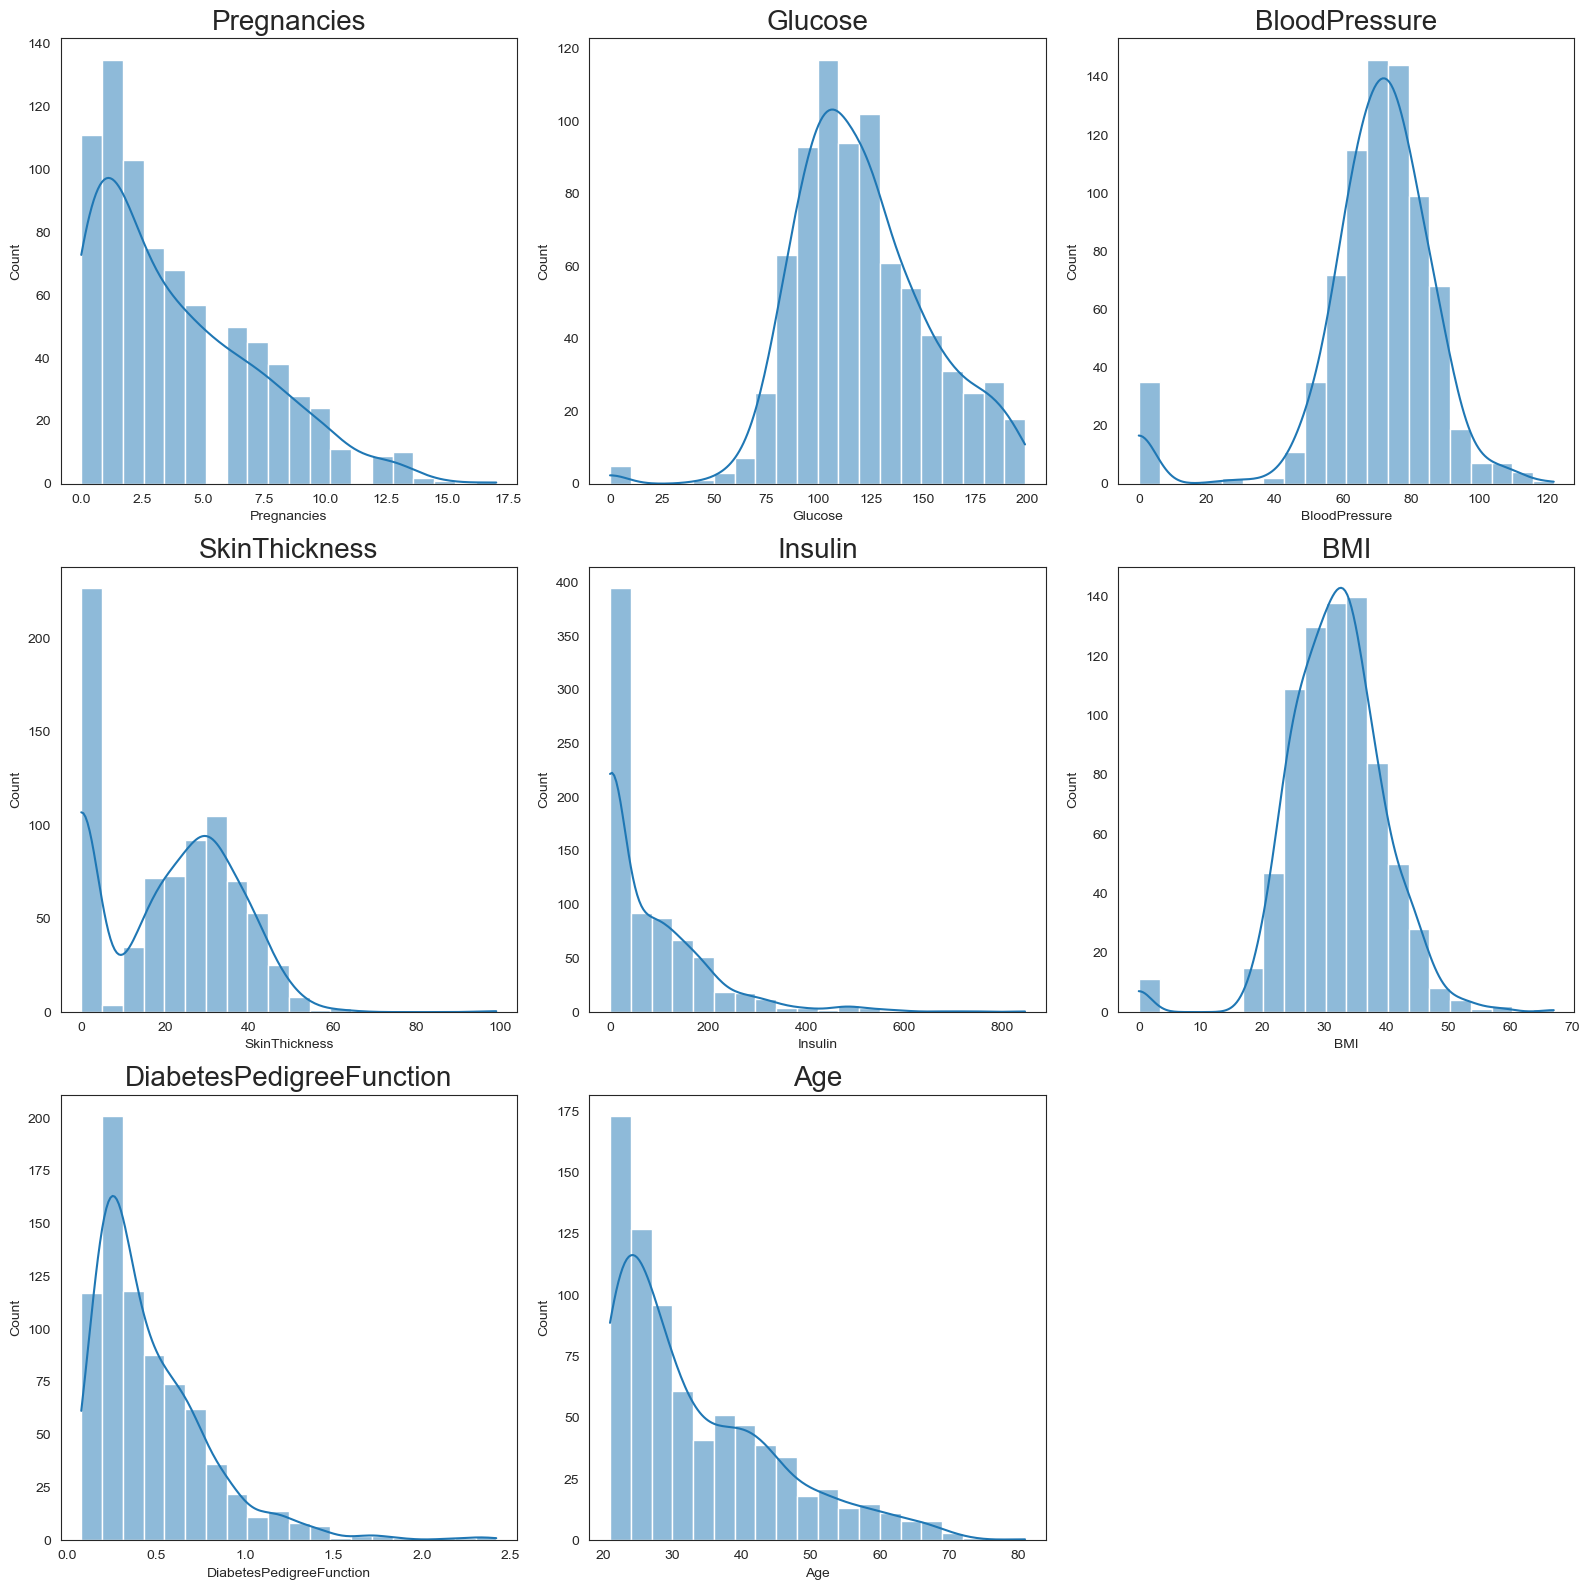

In [51]:
#histgram
sns.set_style("white")
plt.figure(figsize=(16, 16))

i=1 
for col in df.drop(columns='Outcome').columns:
    
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, kde=True, bins=20, multiple="stack", alpha=.5)  
    plt.title(col ,fontsize=20)
    i=i+1 
    
plt.tight_layout()

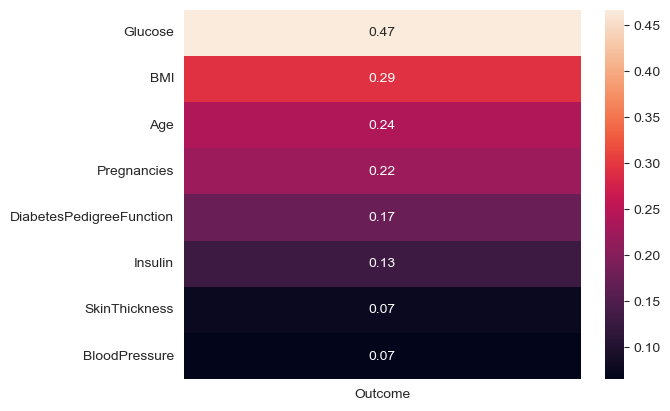

In [52]:
corr = df.corr()
target_corr = corr['Outcome'].drop('Outcome')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.heatmap(target_corr_sorted.to_frame(), annot=True, fmt='.2f')
plt.show()

We can see that some features contain 0, it doesn't make sense here and this indicates missing value Below we replace `0` value by `NaN`.

In [53]:
def replace_zero_with_nan(dataframe, columns):
    dataframe.loc[:,columns] = dataframe[columns].replace(0, np.nan)

replace_zero_with_nan(df, columns=['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI'])

In [54]:
df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [55]:
df['Age_Group'] = pd.cut(df['Age'], bins=[20, 30, 40, 50, 60, 70, float('inf')],
                         labels=['21-30', '31-40', '41-50', '51-60', '61-70', '71-'])

We will fill nulls based on `Age_Group` and `Outcome` columns with the median values of each variable..

In [56]:
df.groupby(['Outcome', 'Age_Group'])['Insulin'].median()

Outcome  Age_Group
0        21-30         94.0
         31-40        119.0
         41-50        105.0
         51-60        190.0
         61-70        185.0
         71-           60.0
1        21-30        160.0
         31-40        171.0
         41-50        152.5
         51-60        222.0
         61-70          NaN
         71-            NaN
Name: Insulin, dtype: float64

We have small problem when imputing `Insulin` column. We will impute some nulls individually becouse there are no values to impute with.

In [57]:
missing_ones = df.isnull().sum()[df.isnull().sum()>0].index

def fill_nulls(data, columns, metric):
    data = data.copy()
    for col in columns:
        data[col] = data[col].fillna(df.groupby(['Outcome', 'Age_Group'])[col].transform(metric))
    return data

df = fill_nulls(df, missing_ones, metric="median")
df['Insulin']=df[['Insulin']].fillna(value= 215)

In [58]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
Age_Group                   0
dtype: int64

In [59]:
df.drop(columns='Age_Group', inplace=True)

In [60]:
def deal_with_outliers(df , columns = None):
    
    if columns is None:
        columns = df.select_dtypes(include=['number']).drop(columns= "Outcome").columns

    for col in columns:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        
        df.loc[(df[col] < lower_bound), col] = lower_bound
        df.loc[(df[col] > upper_bound), col] = upper_bound
            
    return df.head()

In [61]:
deal_with_outliers(df, ['DiabetesPedigreeFunction', 'Insulin', 'BloodPressure', 'SkinThickness', 'BMI' ])

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,152.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,119.0,26.6,0.351,31,0
2,8,183.0,64.0,32.0,171.0,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,1.200,33,1


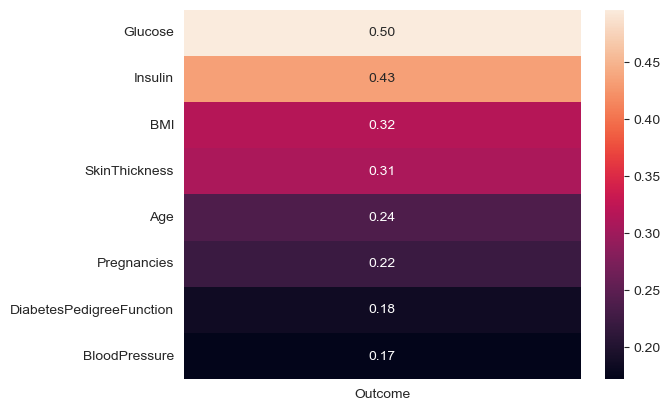

In [62]:
corr = df.corr()
target_corr = corr['Outcome'].drop('Outcome')

# Sort correlation values in descending order
target_corr_sorted = target_corr.sort_values(ascending=False)

sns.heatmap(target_corr_sorted.to_frame(), annot=True, fmt='.2f')
plt.show()

We see how the correlation with target get higher!!  nice work.

### Group BMI column

<p style="text-align:center; ">
<img src="https://www.easy-eye.co.kr/wp-content/uploads/2022/06/%EC%B2%B4%EC%A4%91.jpg" style='width: 500px; height: 350px;'>
</p>

In [63]:
bins = [-float('inf'), 18, 23, 27, 32, 37, float('inf')]
labels = ["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"]

df['New_BMI'] = pd.cut(df['BMI'], bins=bins, labels=labels, right=False)

In [64]:
df = pd.get_dummies(df, columns =["New_BMI"], drop_first = True)

In [65]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,New_BMI_Normal,New_BMI_Overweight,New_BMI_Obesity 1,New_BMI_Obesity 2,New_BMI_Obesity 3
0,6,148.0,72.0,35.0,152.5,33.6,0.627,50,1,0,0,0,1,0
1,1,85.0,66.0,29.0,119.0,26.6,0.351,31,0,0,1,0,0,0
2,8,183.0,64.0,32.0,171.0,23.3,0.672,32,1,0,1,0,0,0
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,0,0,1,0,0
4,0,137.0,40.0,35.0,168.0,43.1,1.200,33,1,0,0,0,0,1


### Applying log-transform:

When our original continuous data do not follow the bell curve, we can log transform this data to make it as “normal” as possible so that the statistical analysis results from this data become more valid. In other words, the log transformation reduces or removes the skewness of our original data. The important caveat here is that the original data has to follow or approximately follow a log-normal distribution. Otherwise, the log transformation won’t work.

In [66]:
df['Age'] = df['Age'].apply(lambda x: np.log(x))
df['DiabetesPedigreeFunction'] = df['DiabetesPedigreeFunction'].apply(lambda x: np.log(x))

# Modeling

In [67]:
target = "Outcome"
X = df.drop(columns= target)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X , y ,
    test_size=0.2,
    random_state=42
)

In [68]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (614, 13)
y_train shape: (614,)
X_test shape: (154, 13)
y_test shape: (154,)


**we will use logistic regression model as base  model.**

In [69]:
lr_classifer = LogisticRegression()
lr_classifer.fit(X_train,y_train)

lr_ytrain_pred = lr_classifer.predict(X_train)
lr_ytest_pred = lr_classifer.predict(X_test)

print('Model accuracy score (train): {:0.2%}'. format(accuracy_score(y_train, lr_ytrain_pred)))
print('Model accuracy score (test): {:0.2%}'. format(accuracy_score(y_test, lr_ytest_pred)))

Model accuracy score (train): 77.69%
Model accuracy score (test): 85.71%


In [70]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, lr_ytest_pred, average='weighted')
recall = recall_score(y_test, lr_ytest_pred, average='weighted')
f1 = f1_score(y_test, lr_ytest_pred, average='weighted')

# Print evaluation metrics
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

Precision: 0.86
Recall: 0.86
F1-score: 0.86


It seems poor model. let's try with Random Forest classifier.

In [71]:
RF_classifer = RandomForestClassifier()
RF_classifer.fit(X_train,y_train)

RF1_ytrain_pred = RF_classifer.predict(X_train)
RF1_ytest_pred = RF_classifer.predict(X_test)

print('Model accuracy score (train): {:0.2%}'. format(accuracy_score(y_train, RF1_ytrain_pred)))
print('Model accuracy score (test): {:0.2%}'. format(accuracy_score(y_test, RF1_ytest_pred)))

Model accuracy score (train): 100.00%
Model accuracy score (test): 85.06%


In [72]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, RF1_ytest_pred, average='weighted')
recall = recall_score(y_test, RF1_ytest_pred, average='weighted')
f1 = f1_score(y_test, RF1_ytest_pred, average='weighted')

# Print evaluation metrics
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

Precision: 0.86
Recall: 0.85
F1-score: 0.85


Random Forest model seems to be overfitting as training accuracy is very high and the validation accuracy is not so.

### Hyperparameter Tuning of Random Forest

In [73]:
param_grid = {
    'n_estimators': [10, 20, 30],  # Adjust the number of trees in the forest
    'max_depth': [10, 20, 30],  # Adjust the maximum depth of each tree
    'min_samples_split': [2, 5, 10, 15, 20],  # Adjust the minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4, 6, 8]  # Adjust the minimum samples required in a leaf node
}

model = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

best_model.fit(X_train, y_train)

RF2_ytrain_pred = best_model.predict(X_train)
RF2_ytest_pred = best_model.predict(X_test)

print('Model accuracy score (train): {:0.2%}'. format(accuracy_score(y_train, RF2_ytrain_pred)))
print('Model accuracy score (test): {:0.2%}'. format(accuracy_score(y_test, RF2_ytest_pred)))


Model accuracy score (train): 92.18%
Model accuracy score (test): 85.06%


In [74]:
# Calculate precision, recall, and F1-score
precision = precision_score(y_test, RF2_ytest_pred, average='weighted')
recall = recall_score(y_test, RF2_ytest_pred, average='weighted')
f1 = f1_score(y_test, RF2_ytest_pred, average='weighted')

# Print evaluation metrics
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

Precision: 0.85
Recall: 0.85
F1-score: 0.85


It has reduced overfitting compared to the initial model. And Improve the accuracy.

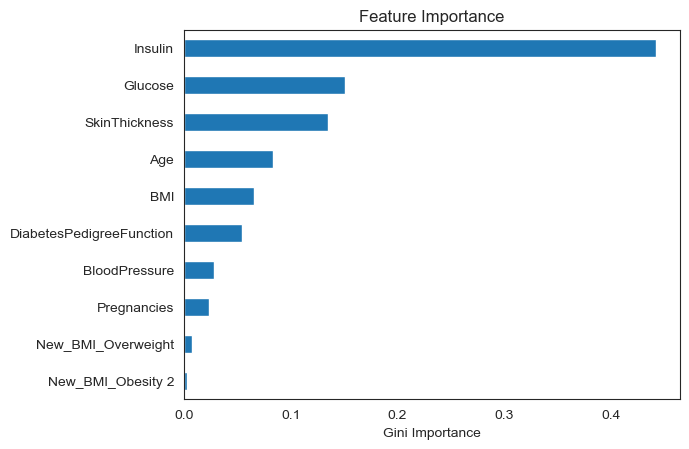

In [75]:
# Get feature names from training data
features = X_train.columns

# Extract importances from model
importances = best_model.feature_importances_

# Create a series with feature names and importances
feat_imp = pd.Series(importances,index=features).sort_values()

# Plot 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Gini Importance")
plt.title("Feature Importance");